# Symmetry breaking in a one-dimensional diffusion model

This introductory tutorial aims to explain the concept of symmetry breaking in generative diffusion models.

## Introduction




### Continous Diffusion Models

The stochastic dynamics of a particle $\mathbf{Y}_0 \sim p(\mathbf{y}, 0)$ starting at time $s=0$ are described as the solution to the Itô SDE: 
$$
d \mathbf{Y}_s = f(\mathbf{Y}_s, s) \text{d}s +g(s)\text{d}\mathbf{\hat{W}}_s
\label{eq:forward sde}
$$

where $f$ and $g$ are the drift and diffusion coefficient chosen properly such that the marginal density will (approximately) converge to a spherical Gaussian steady-state distribution as $s\to  T$. In order to generate samples from $p(\mathbf{y}, 0)$ by starting from the tractable $p(\mathbf{y}, T)$, we can use a "backward'' SDE that reverses this process, whose marginal density evolves according to $p(\mathbf{y},s)$, reverse in time,
\begin{equation} \label{eq: generative sde}
d \mathbf{X}_t = \Big[ g^2(T - t) \nabla_x \log p(\mathbf{X}_t, T-t) - f(\mathbf{X}, T-t)\Big]dt +g(T-t)d\mathbf{W}_t
\end{equation}


For the purpose of our analysis, it is convenient to re-express the generative SDE in in terms of a potential energy function
\begin{equation}
d \mathbf{X}_t = -\nabla_x U(\mathbf{X}_t, T- t)\text{d}t  + g(T-t)\text{d}\mathbf{W}_t
% \label{eq:sde}
\end{equation}
where $U(\mathbf{x}, T- t) =  -g^2(T - t) \log  p(\mathbf{x}, T-t)  + \int_{\mathbf{0}}^\mathbf{x} f(\mathbf{z}, T-t) \text{d}\mathbf{z}$.


#### VP-SDE


$$
    \text{d} \mathbf{Y}_s = - \frac{1}{2} \beta(s) \mathbf{Y}_s + \sqrt{\beta(s)} \text{d}\mathbf{\hat{W}}_s
    \label{eq:ou}
$$




In [1]:
#@title SDE Setup and Euler-Maruyama Numerical Approximation

import os
import torch
import numpy as np

import matplotlib
import seaborn as sns
from cycler import cycler
import matplotlib.pyplot as plt 
from matplotlib.ticker import FormatStrFormatter

# Making the plot outputs portable and reproducible
matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.antialiased'] = True
plt.rcParams['lines.antialiased'] = True
sns.set_theme()

# Allows user interaction
import ipywidgets as widgets
from IPython.display import display


# Setting up a directory for evaluation outputs
eval_dir = os.path.join("./eval_toy_example")
os.makedirs(eval_dir, exist_ok=True)


class DeltaDist:
    """A class used to define a mixture of 2 Deltas with equal probability."""
    def __init__(self, dim, a, b):
        """
        Initializes the mixture of Gaussian distributions.
        The distribution is defined as: 
        p(x) = 1/2 delta(x-(a,a)) + 1/2 \delta((b,b))
        Args:
            dim (int): The dimensionality of the distribution.
            a, b (float): The centers of the Gaussian distributions.
        """
        self.mix_probs = torch.tensor([0.5, 0.5])
        self.means = torch.stack([a * torch.ones(dim), b* torch.ones(dim)], dim=0)

    def sample(self, n):
        """Generates a sample from the distribution."""
        n = n[0]
        mix_idx = torch.multinomial(self.mix_probs, n, replacement=True)
        means = self.means[mix_idx]
        return means
    
    
class VP_SDE:
    """ A class used to define a Stochastic Differential Equation (SDE)."""
    def __init__(self,  beta_min=0.1, beta_max=20, N=1000, T=1, sigma=1):
        """
        Initializes the parameters of the SDE.
        Args:
            beta_min, beta_max (float): The minimum and maximum values of beta.
            N (int): The total number of steps in the Euler Maruyama method.
            T (float): The total time.
            sigma (float): The standard deviation of the distribution.
        """
        self.beta_0 = beta_min
        self.beta_1 = beta_max
        self.N = N
        self.T = T
        self.sigma = sigma

    def f(self, x, t):
        """ Defines the drift term of the SDE. """
        beta_t = self.beta_0 + t * (self.beta_1 - self.beta_0)
        return -0.5 * beta_t * x

    def g(self, t):
        """ Defines the diffusion term of the SDE.m """
        beta_t = self.beta_0 + t * (self.beta_1 - self.beta_0)
        return self.sigma * np.sqrt(beta_t)
    
    
def euler_maruyama(u0, SDE):
    """
    Implements the Euler Maruyama numerical approximation to the SDE.
    Args:
        u0 (np.array): The initial state.
        SDE (object): An instance of the VP_SDE class.
    """

    # Creates time partition based on the SDE configuration
    T=SDE.T; N=SDE.N
    dt = T/N

    # Initial condition.
    U = np.zeros((N+1, len(u0)))
    U[0] = u0

    # Iterate to over the whole time partition, N steps.
    for n in range(N):
        tn = n*dt
        z = np.random.randn(len(u0))
        dW = np.sqrt(dt)*z
        U[n+1] = U[n] + dt*SDE.f(U[n],tn) + SDE.g(tn)*dW
    return U

## SDE parameters

Here we define the process to run over $N=1000$ discrete time steps, with $\beta(t)\in[0.0001, 0.02]$ in $t\in[0,1)$

In [2]:
#@title SDE parameters 
N = 1000        # Total number of steps
beta_min = 0.1  # Minimum value of beta
beta_max = 20   # Maximum value of beta
eps = 1e-3      # A small value for numerical stability
T = 1           # Total time
ts = np.linspace(0, T-eps, N)  # Time partitions

## Forward process 

In [3]:
#@title Forward process for one-dimensional diffusion model
def forward_process(batch_size, a=1, b=-1):
    delta_pdf = DeltaDist(dim=1, a=a, b=b)
    batch = delta_pdf.sample((batch_size,)).numpy().reshape(-1)
    print("Batch size: ", batch.shape)

    sde = VP_SDE(beta_min, beta_max, N, T)
    Us = euler_maruyama(u0=batch, SDE=sde)

    fig = plt.figure(figsize = (9,4))
    plt.plot(Us, alpha=0.6)
    plt.show()

batch_size_slider = widgets.IntSlider(min=1, max=1000, step=1, value=500, description='Batch Size:')
a_slider = widgets.FloatSlider(min=-10.0, max=10.0, step=0.1, value=1.0, description='a:')
b_slider = widgets.FloatSlider(min=-10.0, max=10.0, step=0.1, value=-1.0, description='b:')

out = widgets.interactive_output(forward_process, {'batch_size': batch_size_slider, 'a': a_slider, 'b': b_slider})

display(widgets.VBox([widgets.HBox([batch_size_slider, a_slider, b_slider]), out]))

## Backward process

In [4]:
#@title Backward process for one-dimensional diffusion model
def backward_process(batch_size, a, b):
    # Backward process for one-dimensional diffusion model
    delta_pdf = DeltaDist(dim=1, a=a, b=b)
    batch = delta_pdf.sample((batch_size,)).numpy().reshape(-1)
    print("Batch size: ", batch.shape)

    sde = VP_SDE(beta_min, beta_max, N, T)
    Us = euler_maruyama(u0=batch, SDE=sde)

    # Define the colors to use for the trajectories
    my_colors = np.array(['blue', 'orange'])

    # Determine the colors for all trajectories at once using vectorization
    color_idxs = np.where(Us[0, :] == 1, 0, 1) 
    colors_vec = my_colors[color_idxs]
    custom_cycler = cycler(color=colors_vec)

    fig, ax = plt.subplots(figsize = (9,4)) 
    ax.set_prop_cycle(custom_cycler)
    ax.plot(Us[:650], alpha=0.1)
    plt.gca().invert_xaxis()
    plt.show()

batch_size_slider = widgets.IntSlider(min=1, max=1000, step=1, value=500, description='Batch Size:')
a_slider = widgets.FloatSlider(min=-10.0, max=10.0, step=0.1, value=1.0, description='a:')
b_slider = widgets.FloatSlider(min=-10.0, max=10.0, step=0.1, value=-1.0, description='b:')

out = widgets.interactive_output(backward_process, {'batch_size': batch_size_slider, 'a': a_slider, 'b': b_slider})

display(widgets.VBox([widgets.HBox([batch_size_slider, a_slider, b_slider]), out]))


## Analysis of the Potential Energy

- $\theta_s \in [0,1]$

In [5]:
def theta_fn(s, beta_max=20, beta_min=0.1):
    """
    Estimates theta in discrete time.
    Args:
        s (float or np.ndarray): A value or array of values in the interval [0, 1] for which to calculate theta, s= T- t
        beta_max (float, optional): Maximum beta value. Default is 20.
        beta_min (float, optional): Minimum beta value. Default is 0.1.
    Returns:
        float or np.ndarray: The calculated theta value(s).

    Raises:
        AssertionError: If any value in `s` is not in the interval [0, 1].
    """
    if isinstance(s,(np.ndarray)):
        assert 0<= s.all() <=1, "t \in [0,1]"
    else:
        assert 0<= s <=1, "t \in [0,1]"

    factor = -0.25*s**2*(beta_max-beta_min)-0.5*s*beta_min
    return np.exp(factor)

t in [ 0.0 0.999 ]


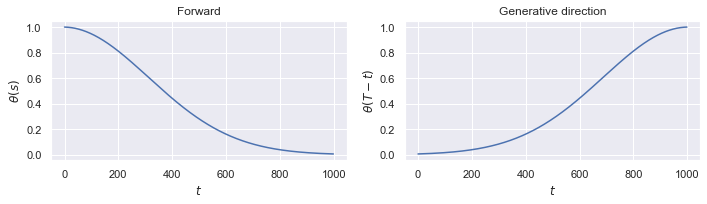

0.006571586494929619


In [6]:
print("t in [", ts.min(), ts.max(), "]")
theta_t= theta_fn(ts)
thetas_T_t= theta_fn(1.-ts)

fig, axs = plt.subplots(1, 2, figsize=(10,3))  # Create a figure and a 1x2 grid of subplots

axs[0].plot(theta_t)
axs[0].set_ylabel(r"$\theta(s)$")
axs[0].set_xlabel("$t$")
axs[0].set_title("Forward")

axs[1].plot(thetas_T_t)
axs[1].set_ylabel(r"$\theta(T-t)$")
axs[1].set_xlabel("$t$")
axs[1].set_title("Generative direction")
# plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

print(thetas_T_t[0]) # must be close to zero

### Potential

In [7]:
def get_time_step(thetas_n, theta_c):
    """ 
    Given a tensor of theta_n values and a specified theta_c value, this function returns the index 
    in the tensor that is closest to the given theta_c value. This index corresponds to the time step
    associated with the closest theta_n value.

    Parameters
    ----------
    thetas_n : torch.Tensor
        A tensor containing thetas_n values. Each thetas_n is the variance level at a particular time step.

    theta_c : torch.Tensor
        A tensor representing a specific variance level. This function will find the time step 
        corresponding to the closest theta_n in 'thetas_n'.
        
    Returns
    -------
    int
        The index of 'thetas_n' that is closest to 'theta_c'. This index represents the time step corresponding 
        to the closest theta_n.
        
    Raises
    ------
    AssertionError
        If 'theta_c' is not in the range [0,1].
    """
    assert 0 <= theta_c.all() <= 1.0, "theta_c should be in [0,1]"

    diff = np.absolute(thetas_n - theta_c)
    return torch.tensor(diff.argmin()).item()


Analytical value critical theta 0.6435942529055827
Critical time,  707
Corresponding Theta_c,  0.6429111305176476


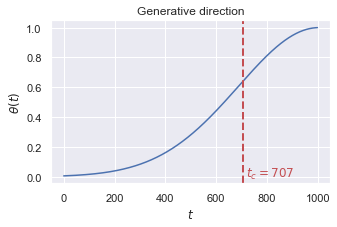

In [8]:
# calculates the time 't' which corresponds to the critical theta

# Compute analytical value for theta critical point
theta_c = np.sqrt(np.sqrt(2)-1)
print("Analytical value critical theta", theta_c)

# Estimate the time corresponding to theta
tc = get_time_step(thetas_T_t, theta_c) 
if tc < 0 or tc >= len(thetas_T_t):
    raise ValueError(f"Invalid critical time: {tc}")
print("Critical time, ", tc)

# Print corresponding Theta_c
print("Corresponding Theta_c, ", thetas_T_t[tc])

# Plotting in the generative direction
fig = plt.figure(figsize=(5,3))
plt.plot(thetas_T_t)
plt.ylabel(r"$\theta(t)$")
plt.xlabel("$t$")
plt.title("Generative direction")
plt.axvline(x=tc, color='r', linestyle='--', linewidth=2)  # Mark the critical time
plt.text(tc+10, 0, r'$t_c={}$'.format(tc), color='r',fontsize=12)  # Add a label for the critical time

# Save and display the plot
fig.savefig(os.path.join(eval_dir, "theta_T_t.png"),  dpi=100, format='png', bbox_inches='tight')
plt.show()

Batch size:  (1000,)


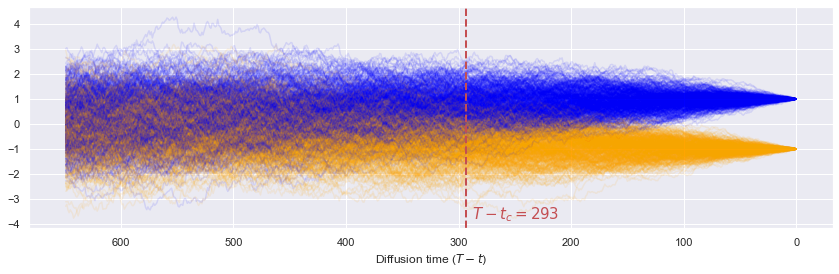

In [9]:
# Backward process for one-dimensional diffusion model
delta_pdf = DeltaDist(dim=1, a=1, b=-1)
batch = delta_pdf.sample((1000,)).numpy().reshape(-1)
print("Batch size: ", batch.shape)

sde = VP_SDE(beta_min, beta_max, N, T)
Us = euler_maruyama(u0=batch, SDE=sde)

# Define the colors to use for the trajectories
my_colors = np.array(['aqua', 'orange'])
my_colors = np.array(['blue', 'orange'])

# Determine the colors for all trajectories at once using vectorization
color_idxs = np.where(Us[0, :] == 1, 0, 1) 
colors_vec = my_colors[color_idxs]
custom_cycler = cycler(color=colors_vec)

fig, ax = plt.subplots(figsize = (14.4,4.07))
ax.set_prop_cycle(custom_cycler)
ax.plot(Us[:650], alpha=0.1)
plt.gca().invert_xaxis()

plt.axvline(x=1000-tc, color='r', linestyle='--', linewidth=2)
plt.text(1000-tc-5, -3.8, r'$T- t_c={}$'.format(1000-tc), color='r',fontsize=15)
plt.xlabel("Diffusion time ($T-t$)")

fig.savefig(os.path.join(os.path.join(eval_dir,"./2D_forward_trajectory_delta_flipped_colors.png")),  dpi=100, format='png', bbox_inches='tight')
plt.show()

In [41]:
#@title Potential function of continous diffusion model

def U(x, t, beta_min=0.1, beta_max=20, T=1.0, N=1000): 
    """
    This function represents the potential function of a continous generative diffusion model.
    
    Input
    ----------
    x : np.ndarray or float
        The value(s) at which the potential function will be evaluated.
    t : np.ndarray or float
        The time(s) at which the potential function will be evaluated.
    beta_min : float, optional
        The minimum value of the inverse temperature beta, by default 0.1
    beta_max : float, optional
        The maximum value of the inverse temperature beta, by default 20
    T : float, optional
        The total time for the SDE to run, by default 1.0
    N : int, optional
        The total number of time steps for the SDE, by default 1000

    Returns
    -------
    np.ndarray or float
        The value(s) of the potential function at the given x and t.
    """
    beta_t = beta_min + (T-t) * (beta_max - beta_min) 
    print(beta_t)
    theta = theta_fn(T-t, beta_max=beta_max, beta_min=beta_min)
    exp1 = np.exp(-0.5 * (x - theta)**2 / (1 - theta**2))
    exp2 = np.exp(-0.5 * (x + theta)**2 / (1 - theta**2))

    log_term = np.log(exp1 + exp2) 
    print(beta_t, theta)
    return  beta_t * (-0.25 * x**2  + 2*np.sqrt(2*np.pi*(1-theta**2))-log_term)

In [47]:
#@title The potential changes forms due to symmetry breaking at tc
#Note: we consider t in [0,1] in continous time, for discrete time 1000*t
def plot_potential(x_start, x_end, t):
    x = np.linspace(x_start, x_end, 1000)
    potential = U(x, t)
    plt.figure(figsize=(5,4))
    plt.plot(x, potential)
    plt.title(f"Potential for time t={t}")  # Add time in title
    plt.show()

# Define sliders
x_start_slider = widgets.FloatSlider(min=-5.0, max=0.0, step=0.1, value=-10.0, description='x Start:')
x_end_slider = widgets.FloatSlider(min=0.0, max=5.0, step=0.1, value=10.0, description='x End:')
t_slider = widgets.FloatSlider(min=0.0, max=1.0-0.025, step=0.01, value=0.707, description='t:')

out = widgets.interactive_output(plot_potential, {'x_start': x_start_slider, 'x_end': x_end_slider, 't': t_slider})

# Display widgets
display(widgets.VBox([widgets.HBox([x_start_slider, x_end_slider, t_slider]), out]))


14.029999999999998
14.029999999999998 0.08435257018282653


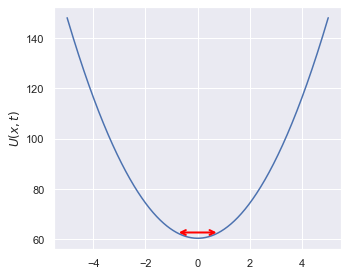

5.9307
5.9307 0.6429111305176476


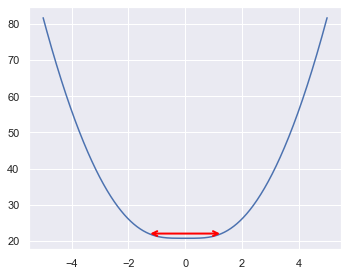

3.0850000000000004
3.0850000000000004 0.8874194698027081


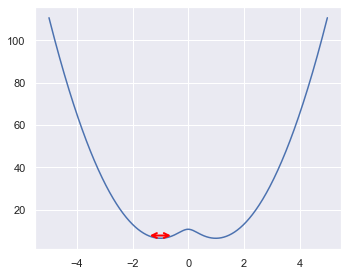

In [48]:
# The code plots the potential energy for three different time points
# For each time point, it also adds an arrow indicating the 'spread' 
# around the minima of the potential energy curve.

x = np.linspace(5, -5, 1000)

# We predefine x values for which the spread will be computed, and the corresponding spread values
xs = [0.8, 1.3, 1.5]
spreads = [2.3, 1.3, 1.3]

# We iterate over the predefined time points
for j, i in enumerate([300, tc, 850]):
    # Create a subplot
    fig, ax = plt.subplots(figsize=(5, 4))
    
    # Compute the potential energy at each x value
    potential = U(x, t=i/N)
    plt.plot(x, potential) 

    # Add horizontal line at the minima
    minima = np.min(potential)
    spread = -spreads[j] # Adjust the spread value as needed

    # Add y-axis label for the first plot
    if j==0: 
        ax.set_ylabel(r'$U(x, t)$')

    # Add spread annotation for the last plot
    if j==2: 
        plt.annotate('', xy=(-1.45, minima - spread), xytext=(-0.55, minima - spread),
                     arrowprops=dict(arrowstyle='<->', color='red', linewidth=2))
    else:
        plt.annotate('', xy=(-xs[j], minima - spread), xytext=(xs[j], minima - spread),
                 arrowprops=dict(arrowstyle='<->', color='red', linewidth=2))
    
    # Adjust the plot layout and save the figure
    plt.tight_layout()
    fig.savefig(os.path.join(eval_dir, "potentials_{}.png".format(j)),  dpi=200, format='png', bbox_inches='tight')

    # Display the plot and close it to free up memory
    plt.show()
    plt.close()


14.029999999999998
14.029999999999998 0.08435257018282653
5.9307
5.9307 0.6429111305176476
3.0850000000000004
3.0850000000000004 0.8874194698027081


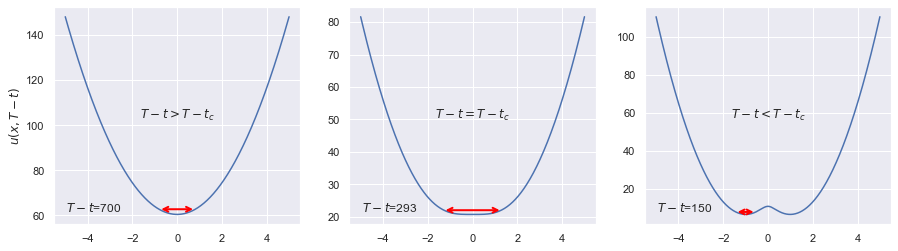

In [49]:
xs = [0.8, 1.3, 1.5]
spreads = [2.3, 1.3, 1.3]

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for j, i in enumerate([300, tc, 850]):
    ax = axs[j]
    # Compute the potential energy at each x value
    potential = U(x, t=i/N)
    ax.plot(x, potential) 

    # Add horizontal line at the minima
    minima = np.min(potential)
    spread = -spreads[j]  # Adjust the spread value as needed
    
    # Get the x-axis and y-axis limits of the previous plot
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # Calculate the center coordinates
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
        
    if j == 0:
        ax.set_ylabel(r'$u(x, T- t)$')
        # Add the annotation
        text = r'$T -t  > T - t_c$'
        ax.text(center_x, center_y, text, fontsize=12, ha='center', va='center')

    if j==1: 
        text = r'$T -t = T - t_c$'
        ax.text(center_x, center_y, text, fontsize=12, ha='center', va='center')
        
    if j == 2:
        # Add arrows to show the spread
        ax.annotate('', xy=(-1.45, minima - spread), xytext=(-0.55, minima - spread),
                     arrowprops=dict(arrowstyle='<->', color='red', linewidth=2))
        text = r'$T -t < T - t_c$'
        ax.text(center_x, center_y, text, fontsize=12, ha='center', va='center')
    else:
        # Add arrows to show the spread
        ax.annotate('', xy=(-xs[j], minima - spread), xytext=(xs[j], minima - spread),
                     arrowprops=dict(arrowstyle='<->', color='red', linewidth=2))

      # add text centered 
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim() 
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    # ax.text(x_min+1, y_min+1, r"$T- t$={}".format(1000-i), fontsize=12, ha='center', va='center')
    
    # place text in lower left side of plot
    padding = 0.05  # adjust as needed for padding from edge of plot
    ax.text(x_min + (x_max - x_min) * padding, y_min + (y_max - y_min) * padding,
            r"$T- t$={}".format(1000-i), fontsize=12, ha='left', va='bottom')


    # Set the formatter for y-axis tick labels
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

fig.savefig(os.path.join(eval_dir, "potentials.png"), dpi=200, format='png', bbox_inches='tight')

plt.show()
plt.close()


18.01
18.01 0.016996463261689278
14.029999999999998
14.029999999999998 0.08435257018282653
5.9307
5.9307 0.6429111305176476
3.0850000000000004
3.0850000000000004 0.8874194698027081


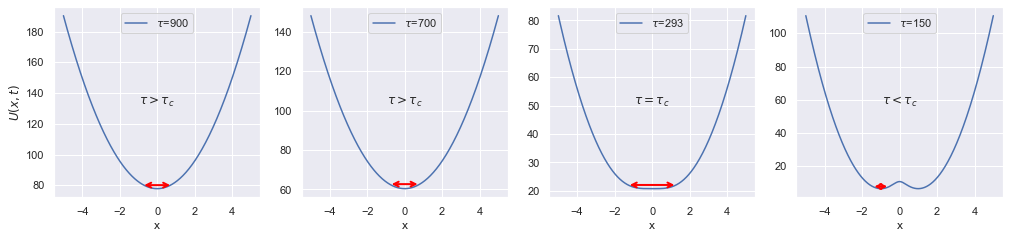

In [50]:
xs = [0.8, 0.8, 1.3, 1.5]
spreads = [2.3, 2.3, 1.3, 1.3]

fig, axs = plt.subplots(1, 4, figsize=(17, 3.5), sharey=False)

for j, i in enumerate([100, 300, tc, 850]):
    ax = axs[j]
    # Compute the potential energy at each x value
    potential = U(x, t=i/N)
    ax.plot(x, potential, label=r"$\tau$={}".format(1000-i))
    ax.legend()

    # Add horizontal line at the minima
    minima = np.min(potential)
    spread = -spreads[j]  # Adjust the spread value as needed
    
    # Get the x-axis and y-axis limits of the previous plot
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # Calculate the center coordinates
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
        
    if j == 0:
        ax.set_ylabel(r'$U(x, t)$')
        # Add the annotation
        text = r'$\tau > \tau_c$'
        ax.text(center_x, center_y, text, fontsize=12, ha='center', va='center')
    
    if j == 1:
        # Add the annotation
        text = r'$\tau > \tau_c$'
        ax.text(center_x, center_y, text, fontsize=12, ha='center', va='center')
        
    if j==2: 
        text = r'$\tau = \tau_c$'
        ax.text(center_x, center_y, text, fontsize=12, ha='center', va='center')
        
    if j == 3:
        # Add arrows to show the spread
        ax.annotate('', xy=(-1.45, minima - spread), xytext=(-0.55, minima - spread),
                     arrowprops=dict(arrowstyle='<->', color='red', linewidth=2))
        text = r'$\tau < \tau_c$'
        ax.text(center_x, center_y, text, fontsize=12, ha='center', va='center')
    else:
        # Add arrows to show the spread
        ax.annotate('', xy=(-xs[j], minima - spread), xytext=(xs[j], minima - spread),
                     arrowprops=dict(arrowstyle='<->', color='red', linewidth=2))
    
   
    # Adjust the location of the legend
    ax.legend(loc='upper center')
    ax.set_xlabel('x')

    # Set the formatter for y-axis tick labels
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

fig.savefig(os.path.join(eval_dir, "potentials.png"), dpi=200, format='png', bbox_inches='tight')

plt.show()
plt.close()

## Estimate second derivative

Evaluation running from 1 -> 0.001 this avoids dividing by zero

In [51]:
thetas_T_t[:10]

array([0.00657159, 0.0066376 , 0.00670421, 0.00677142, 0.00683923,
       0.00690766, 0.0069767 , 0.00704636, 0.00711665, 0.00718756])

In [25]:
beta_T_t = beta_min + (T-ts) * (beta_max-beta_min)
second_derivative = -beta_T_t*(.5 + (2*thetas_T_t**2 - 1)/(thetas_T_t**2 -1)**2)

# compute analytical value for theta critical point
theta_c = np.sqrt(np.sqrt(2)-1)
print("analytical value critical theta", theta_c)

analytical value critical theta 0.6435942529055827


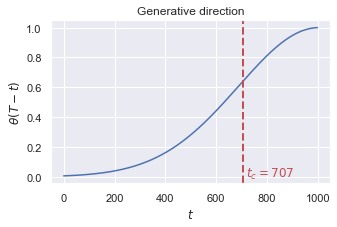

In [26]:
# Plotting in the generative direction 
fig = plt.figure(figsize=(5,3))
plt.plot(thetas_T_t)
plt.ylabel(r"$\theta(T-t)$")
plt.xlabel("$t$")
plt.title("Generative direction")
plt.axvline(x=tc, color='r', linestyle='--', linewidth=2)
plt.text(tc+10, 0, r'$t_c={}$'.format(tc), color='r',fontsize=12)

# plt.gca().invert_xaxis()
fig.savefig(os.path.join(eval_dir, "theta_T_t.png"),  dpi=100, format='png', bbox_inches='tight')
plt.show()

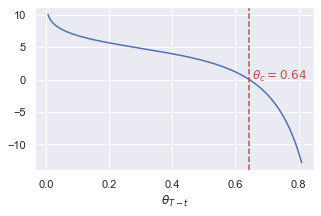

In [31]:
offset=800
fig = plt.figure(figsize=(5,3))
plt.plot(thetas_T_t[:offset], second_derivative[:offset])
plt.axvline(x=theta_c, color='r', linestyle='--')
plt.text(theta_c+.01, 0, r'$\theta_c={:0.2f}$'.format(theta_c), color='r')
plt.xlabel(r'$\theta_{T-t}$')
# plt.ylabel(r"$\frac{\partial^2 U}{\partial x^2}|_{x=0}$")
fig.savefig(os.path.join(eval_dir, "./critical_point_theta.png"),  dpi=100, format='png', bbox_inches='tight')
plt.show()

In [33]:
(1-ts)[707]

0.29300000000000004

In [34]:
sde = VP_SDE(beta_min=0.1, beta_max=20, N=1000, T=1)
Us = euler_maruyama(u0=batch, SDE=sde)

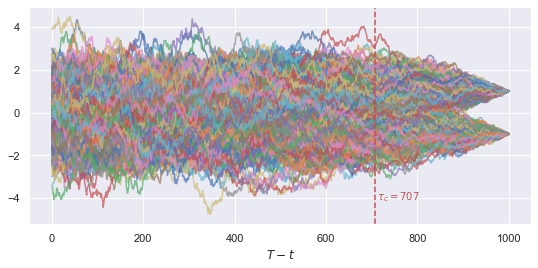

In [35]:
fig = plt.figure(figsize = (9,4))
plt.plot(np.flip(Us, axis=0), alpha=0.7)
plt.axvline(x=707, color='r', linestyle='--')
plt.text(tc+5, -4.1, r'$\tau_c={}$'.format(tc), color='r',fontsize=10)
plt.xlabel(r'$T - t$')
plt.xlabel(r'$T - t$')
fig.savefig(os.path.join(os.path.join(eval_dir,"./2D_forward_trajectory_delta_flipped.png")),  dpi=300, format='png', bbox_inches='tight')
plt.show()

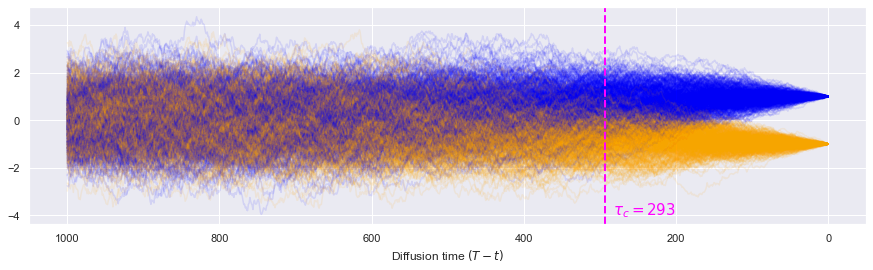

In [71]:
from cycler import cycler

# Define the colors to use for the trajectories
my_colors = np.array(['aqua', 'orange'])
my_colors = np.array(['blue', 'orange'])

# Determine the colors for all trajectories at once using vectorization
color_idxs = np.where(Us[0, :] == 1, 0, 1) 
colors_vec = my_colors[color_idxs]
custom_cycler = cycler(color=colors_vec)

fig, ax = plt.subplots(figsize = (15,4))
ax.set_prop_cycle(custom_cycler)
ax.plot(Us, alpha=0.1)
plt.gca().invert_xaxis()

plt.axvline(x=1000-707, color='Magenta', linestyle='--', linewidth=2)
plt.text(1000-tc-10, -4., r'$\tau_c={}$'.format(1000-tc), color='Magenta',fontsize=15)
plt.xlabel("Diffusion time $(T-t)$")

fig.savefig(os.path.join(os.path.join(eval_dir,"./2D_forward_trajectory_delta_flipped_colors.png")),  dpi=300, format='png', bbox_inches='tight')
# 
plt.show()

In [72]:
# Us[0]

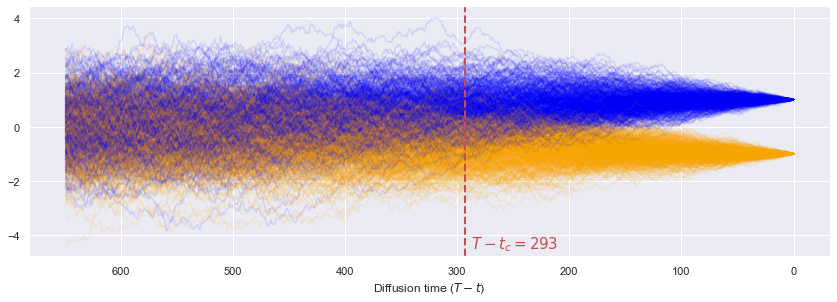

In [67]:
fig, ax = plt.subplots(figsize = (14.35,4.6))
ax.set_prop_cycle(custom_cycler)
ax.plot(Us[:650], alpha=0.1)
plt.gca().invert_xaxis()

plt.axvline(x=1000-707, color='r', linestyle='--', linewidth=2)
plt.text(1000-tc-5, -4.5, r'$T- t_c={}$'.format(1000-tc), color='r',fontsize=15)
plt.xlabel("Diffusion time ($T-t$)")

fig.savefig(os.path.join(os.path.join(eval_dir,"./2D_forward_trajectory_delta_flipped_colors.png")),  dpi=100, format='png', bbox_inches='tight')
# 
plt.show()

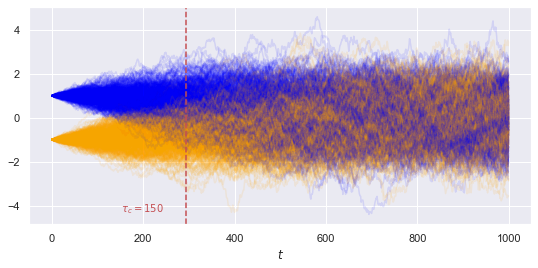

In [88]:
# Not flipped 

from cycler import cycler

# Define the colors to use for the trajectories
my_colors = np.array(['aqua', 'orange'])
my_colors = np.array(['blue', 'orange'])

# Determine the colors for all trajectories at once using vectorization
color_idxs = np.where(Us[0, :] == 1, 0, 1) 
colors_vec = my_colors[color_idxs]
custom_cycler = cycler(color=colors_vec)

fig, ax = plt.subplots(figsize = (9,4))
ax.set_prop_cycle(custom_cycler)
ax.plot(Us, alpha=0.1)
# plt.gca().invert_xaxis()

plt.axvline(x=1000-707, color='r', linestyle='--')
plt.text(1000-tc, -4.3, r'$\tau_c={}$'.format(1000-tc), color='r',fontsize=10)
plt.xlabel(r'$t$')

fig.savefig(os.path.join(os.path.join(eval_dir,"./2D_forward_trajectory_delta_flipped_colors.png")),  dpi=300, format='png', bbox_inches='tight')

plt.show()


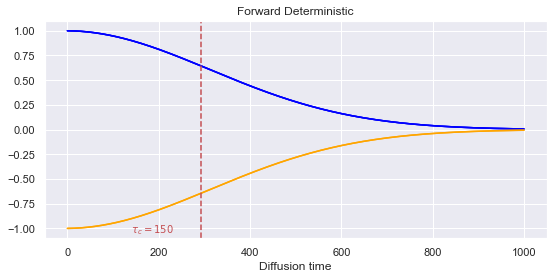

In [89]:
sde = VP_SDE(beta_min=0.1, beta_max=20, N=1000, T=1, sigma=0)
Us = euler_maruyama(u0=batch[:5], SDE=sde)

fig, ax = plt.subplots(figsize = (9,4))
ax.set_prop_cycle(custom_cycler)
ax.plot(Us, alpha=1)
# plt.gca().invert_xaxis()

plt.axvline(x=1000-707, color='r', linestyle='--')
plt.text(1000-tc-10, -1.05, r'$\tau_c={}$'.format(1000-tc), color='r',fontsize=10)
plt.xlabel("Diffusion time")
plt.title("Forward Deterministic") 
fig.savefig(os.path.join(os.path.join(eval_dir,"./2D_forward_trajectory_delta_deterministic.png")),  dpi=300, format='png', bbox_inches='tight')
plt.show()

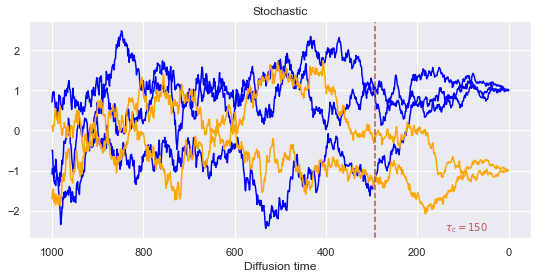

In [90]:
# Set random seed for reproducibility
# np.random.seed(45)

sde = VP_SDE(beta_min=0.1, beta_max=20, N=1000, T=1, sigma=1)
Us = euler_maruyama(u0=batch[:5], SDE=sde)

fig, ax = plt.subplots(figsize = (9,4))
ax.set_prop_cycle(custom_cycler)
ax.plot(Us, alpha=1)
plt.gca().invert_xaxis()

plt.axvline(x=1000-707, color='r', linestyle='--')
plt.text(1000-tc-10, -2.5, r'$\tau_c={}$'.format(1000-tc), color='r',fontsize=10)
plt.xlabel("Diffusion time")
plt.title("Stochastic") 
fig.savefig(os.path.join(os.path.join(eval_dir,"./2D_forward_trajectory_delta_flipped.png")),  dpi=300, format='png', bbox_inches='tight')
plt.show()

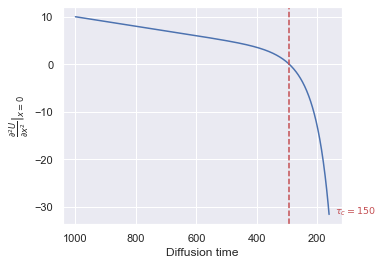

In [91]:
offset=840
fig = plt.figure(figsize=(5,4))
plt.plot((1-ts[:offset])*1000, second_derivative[:offset])
# plt.plot(thetas[:offset], second_derivative[:offset])
plt.axvline(x=1000-707, color='r', linestyle='--')
# plt.axvline(x=0.643, color='r', linestyle='--')
plt.text(1000-tc-10, -31.5, r'$\tau_c={}$'.format(1000-tc), color='r',fontsize=9.5)
plt.xlabel("Diffusion time")
plt.ylabel(r"$\frac{\partial^2 U}{\partial x^2}|_{x=0}$")
plt.gca().invert_xaxis()
fig.savefig(os.path.join(eval_dir, "./critical_point_time_reverted.png"),  dpi=300, format='png', bbox_inches='tight')
plt.show()

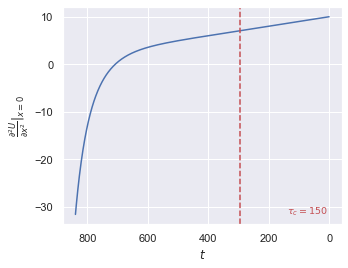

In [92]:
#not flipped

offset=840
fig = plt.figure(figsize=(5,4))
plt.plot(second_derivative[:offset])
# plt.plot(thetas[:offset], second_derivative[:offset])
plt.axvline(x=1000-707, color='r', linestyle='--')
# plt.axvline(x=0.643, color='r', linestyle='--')
plt.text(1000-tc-10, -31.5, r'$\tau_c={}$'.format(1000-tc), color='r',fontsize=9.5)
plt.xlabel(r'$t$')
plt.ylabel(r"$\frac{\partial^2 U}{\partial x^2}|_{x=0}$")
plt.gca().invert_xaxis()
# fig.savefig(os.path.join(eval_dir, "./critical_point_time_reverted.png"),  dpi=300, format='png', bbox_inches='tight')
plt.show()


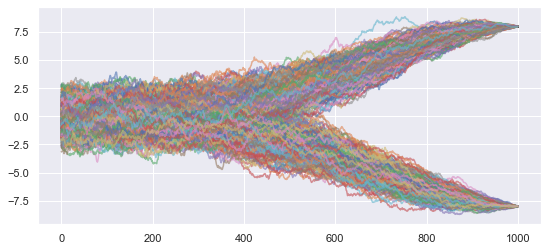

In [93]:
a = 8
delta_pdf = DeltaDist(dim=1, a=a, b=-a)
batch = delta_pdf.sample((1000,)).numpy().reshape(-1)

sde = VP_SDE(beta_min=0.1, beta_max=20, N=1000, T=1)
Us = euler_maruyama(u0=batch, SDE=sde)

fig = plt.figure(figsize = (9,4))
plt.plot(np.flip(Us, axis=0), alpha=0.6)
plt.show()

In [94]:
# import warnings
# warnings.filterwarnings('ignore')

class Reverse_SDE():
    def __init__(self,  beta_min=0.1, beta_max=20, N=1000, T=1, deterministic=False):
        self.beta_0 = beta_min
        self.beta_1 = beta_max
        self.N = N
        self.T = T
        self.deterministic = deterministic

    def f(self, x, t):
        theta = theta_fn(self.T-t)
        beta_t = self.beta_0 + (self.T-t) * (self.beta_1 - self.beta_0)
        if np.abs(theta**2 - 1) < 1e-3:
            exp1 = 0
        else:
            exp1 = np.exp(2*theta*x / (theta**2-1)) 
        fraction = ((theta*(exp1 -1) / (exp1 +1)) + x ) / (theta**2 - 1) 
        return - beta_t * (  0.5*x - 0.5*fraction) if self.deterministic else - beta_t * (  0.5*x - fraction)

    def g(self, t):
        beta_t = self.beta_0 + (T-t) * (self.beta_1 - self.beta_0)
        return 0 if self.deterministic else np.sqrt(beta_t)

# To do : fix this numerical implementation

C:\Users\20210512\AppData\Local\Temp/ipykernel_34284/3009857917.py:18: RuntimeWarning: overflow encountered in exp
  exp1 = np.exp(2*theta*x / (theta**2-1))
C:\Users\20210512\AppData\Local\Temp/ipykernel_34284/3009857917.py:19: RuntimeWarning: invalid value encountered in true_divide
  fraction = ((theta*(exp1 -1) / (exp1 +1)) + x ) / (theta**2 - 1)


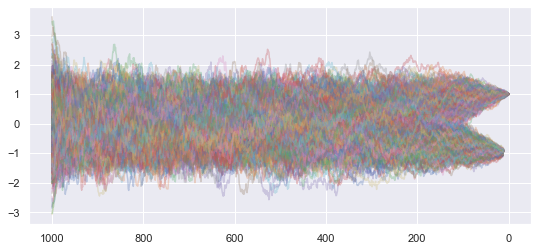

In [95]:
sde = Reverse_SDE(beta_min=0.1, beta_max=20, N=1000, T=1)
Us = euler_maruyama(u0=np.random.normal(size=1000), SDE=sde)

fig = plt.figure(figsize = (9,4))
plt.plot(np.flip(Us, axis=0), alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

C:\Users\20210512\AppData\Local\Temp/ipykernel_34284/3009857917.py:18: RuntimeWarning: overflow encountered in exp
  exp1 = np.exp(2*theta*x / (theta**2-1))
C:\Users\20210512\AppData\Local\Temp/ipykernel_34284/3009857917.py:19: RuntimeWarning: invalid value encountered in true_divide
  fraction = ((theta*(exp1 -1) / (exp1 +1)) + x ) / (theta**2 - 1)


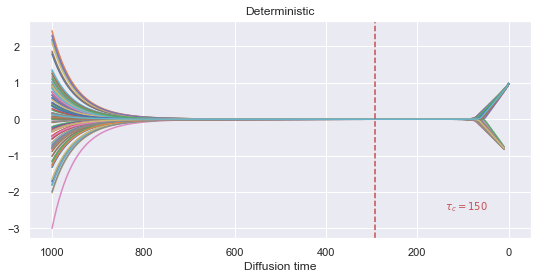

In [96]:
sde = Reverse_SDE(beta_min=0.1, beta_max=20, N=1000, T=1, deterministic=True)
Us = euler_maruyama(u0=np.random.normal(size=100), SDE=sde)

fig = plt.figure(figsize = (9,4))
plt.plot(np.flip(Us, axis=0), alpha=1)
plt.gca().invert_xaxis() 
ax.set_prop_cycle(custom_cycler)
plt.axvline(x=1000-707, color='r', linestyle='--')
plt.text(1000-tc-10, -2.5, r'$\tau_c={}$'.format(1000-tc), color='r',fontsize=10)
plt.xlabel("Diffusion time")
plt.title("Deterministic")  
fig.savefig(os.path.join(os.path.join(eval_dir,"./2D_forward_trajectory_delta_deterministic.png")),  dpi=300, format='png', bbox_inches='tight')
plt.show()

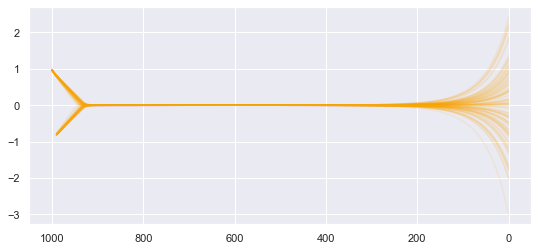

In [97]:
from cycler import cycler
# Define the colors to use for the trajectories
my_colors = np.array(['blue', 'orange'])


# Determine the colors for all trajectories at once using vectorization
# color_idxs = np.where(Us[0, :] == 1, 0, 1) 
color_idxs = np.where(Us[-1, :] == 1, 0, 1)

colors_vec = my_colors[color_idxs]
custom_cycler = cycler(color=colors_vec)

fig, ax = plt.subplots(figsize = (9,4))
ax.set_prop_cycle(custom_cycler)
ax.plot(Us, alpha=0.1)
plt.gca().invert_xaxis()
plt.show()

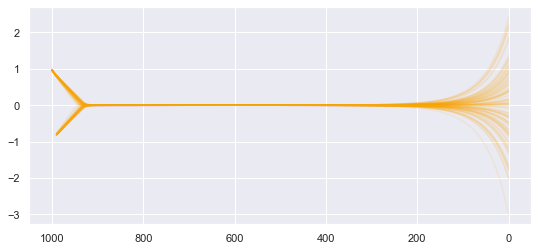

In [98]:
from cycler import cycler

# Define the colors to use for the trajectories
my_colors = np.array(['blue', 'orange'])


# Determine the colors for all trajectories at once using vectorization
color_idxs = np.where(Us[0, :] == 1, 0, 1) 
colors_vec = my_colors[color_idxs]
custom_cycler = cycler(color=colors_vec)

fig, ax = plt.subplots(figsize = (9,4))
ax.set_prop_cycle(custom_cycler)
ax.plot(Us, alpha=0.1)
plt.gca().invert_xaxis()
plt.show()

## Estimating the other unstable points


$y = f(x)$, where $y = (1 - \theta_{T-t}^2) x^*$ and $f(x) = 2 \theta_{T-t} \tanh{\left(\frac{ \theta_{T-t} x}{\theta_{T-t}^2 - 1} \right)}$, and then plot the two functions $y$ and $f(x)$ on the same graph. The intersection points of the two functions correspond to the solutions of the original equation.

Here's an example of how to plot the intersection points graphically in Python:

python


In [103]:
theta = thetas.copy()

The intersection points are: []


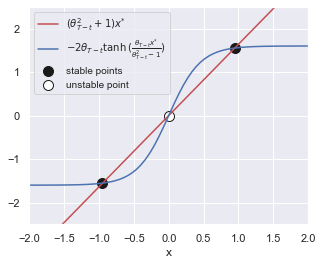

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# define the function f(x, theta)
def f(x, theta):
    return -2 * theta * np.tanh((theta * x) / (theta**2 - 1))
 
# define the range of values for x
# x = np.linspace(-3, 3, len(theta))
x = np.linspace(-3, 3, 100)

# compute the function y(x)
# theta = 0.643  # set the value of theta
theta = 0.8 #np.sqrt(np.sqrt(2)-1)
# y = (1 - theta**2) * x
y = (theta**2 + 1) * x

f = f(x, theta)

fig = plt.figure(figsize=(5,4))
# plot the functions y and f(x)
plt.plot(x, y, 'r', label=r"$(\theta^2_{T-t}+1)x^{*}$")
plt.plot(x, f, label=r"$-2\theta_{T-t}\tanh{(\frac{\theta_{T-t}x^{*}}{\theta_{T-t}^2-1}})$")

# find the intersection points
intersection_points = np.intersect1d(x, np.roots(np.array([1+theta**2, 2*theta/(theta**2-1), 0, -2*theta/(theta**2-1)])))
print(f"The intersection points are: {intersection_points}")

# plot the intersection points
# for intersection_point in intersection_points:
#     plt.scatter(intersection_point, f(intersection_point, theta), color='k')

    
plt.scatter(-0.96, -1.55, color="k", edgecolors='k', s=100)
plt.scatter(.95, 1.55, color="k", edgecolors='k', label="stable points", s=100)
plt.scatter(-0.0, 0.0, color="w", edgecolors='k', label="unstable point", s=100)
plt.ylim([-2.5, 2.5])
plt.xlim([-2, 2])
plt.xlabel('x')

plt.legend(fontsize=10)
# Add this to control the size of legend markers
lgnd = plt.legend(loc="best", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [10]
lgnd.legendHandles[1]._sizes = [10]

fig.savefig(os.path.join(os.path.join(eval_dir,"./1D_intersection_points.png")),  dpi=300, format='png', bbox_inches='tight')
plt.show()

In [165]:
import numpy as np

 

# Combine the arrays using stack
Y = np.stack((x, y), axis=1)
F = np.stack((x, f), axis=1)


nrows, ncols = Y.shape
dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [Y.dtype]}

C = np.intersect1d(Y.view(dtype), F.view(dtype))

# This last bit is optional if you're okay with "C" being a structured array...
C = C.view(Y.dtype).reshape(-1, ncols)
# C
C

array([], shape=(0, 2), dtype=float64)

In [166]:
F

array([[-3.        , -1.28224118],
       [-2.99399399, -1.2821938 ],
       [-2.98798799, -1.28214579],
       ...,
       [ 2.98798799,  1.28214579],
       [ 2.99399399,  1.2821938 ],
       [ 3.        ,  1.28224118]])

In [163]:
Y

array([[-3.        , -1.75999583],
       [-2.93939394, -1.72444036],
       [-2.87878788, -1.68888489],
       [-2.81818182, -1.65332942],
       [-2.75757576, -1.61777395],
       [-2.6969697 , -1.58221848],
       [-2.63636364, -1.54666301],
       [-2.57575758, -1.51110753],
       [-2.51515152, -1.47555206],
       [-2.45454545, -1.43999659],
       [-2.39393939, -1.40444112],
       [-2.33333333, -1.36888565],
       [-2.27272727, -1.33333018],
       [-2.21212121, -1.29777471],
       [-2.15151515, -1.26221924],
       [-2.09090909, -1.22666376],
       [-2.03030303, -1.19110829],
       [-1.96969697, -1.15555282],
       [-1.90909091, -1.11999735],
       [-1.84848485, -1.08444188],
       [-1.78787879, -1.04888641],
       [-1.72727273, -1.01333094],
       [-1.66666667, -0.97777546],
       [-1.60606061, -0.94221999],
       [-1.54545455, -0.90666452],
       [-1.48484848, -0.87110905],
       [-1.42424242, -0.83555358],
       [-1.36363636, -0.79999811],
       [-1.3030303 ,

In [158]:
import numpy as np

A = np.array([[1,4],[2,5],[3,6]])
B = np.array([[1,4],[3,6],[7,8]])

A = np.stack((x, y), axis=1)
B = np.stack((x, f), axis=1)

nrows, ncols = A.shape
dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [A.dtype]}

C = np.intersect1d(A.view(dtype), B.view(dtype))

# This last bit is optional if you're okay with "C" being a structured array...
C = C.view(A.dtype).reshape(-1, ncols)


C

array([], shape=(0, 2), dtype=float64)

In [159]:
dtype

{'names': ['f0', 'f1'], 'formats': [dtype('float64'), dtype('float64')]}

In [135]:

def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

p1 = np.array([0.0, 0.0])
p2 = np.array( [1.0, 0.0] )

p3 = np.array( [4.0, -5.0] )
p4 = np.array( [4.0, 2.0] )

print(seg_intersect( p1,p2, p3,p4))

p1 = np.array( [2.0, 2.0] )
p2 = np.array( [4.0, 3.0] )

p3 = np.array( [6.0, 0.0] )
p4 = np.array( [6.0, 3.0] )

print(seg_intersect( p1,p2, p3,p4))

[4. 0.]
[6. 4.]


In [109]:
print(seg_intersect( x,p2, p3,p4))

Intersection point 1: (1, 2) and (1, 1)
Intersection point 2: (2, 4) and (2, 4)
Intersection point 3: (3, 6) and (3, 9)
Intersection point 4: (4, 8) and (4, 16)
Intersection point 5: (5, 10) and (5, 25)


In [110]:
import numpy as np

# Define the two pairs of arrays
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 6, 8, 10])
f = np.array([1, 4, 9, 16, 25])

# Find the common elements in the x array
common_x = np.intersect1d(x, x)

# Find the corresponding indices for each common x value
common_x_indices_y = np.where(np.in1d(x, common_x))[0]
common_x_indices_f = np.where(np.in1d(x, common_x))[0]

# Find the common y and f values at those indices
common_y = y[common_x_indices_y]
common_f = f[common_x_indices_f]

# Find the indices where both y and f match
common_indices = np.where(common_y == common_f)[0]

# Print the intersection points
for i in common_indices:
    print(f"Intersection point {i+1}: ({common_x[i]}, {common_y[i]}) and ({common_x[i]}, {common_f[i]})")


Intersection point 2: (2, 4) and (2, 4)


In [104]:
f[:20]

array([-1.28224118, -1.28173326, -1.28115344, -1.28049156, -1.27973608,
       -1.27887381, -1.27788977, -1.27676685, -1.27548561, -1.27402393,
       -1.27235664, -1.27045515, -1.26828699, -1.26581532, -1.26299837,
       -1.25978885, -1.25613325, -1.25197116, -1.24723445, -1.24184642])

C:\Users\20210512\AppData\Local\Temp/ipykernel_1092/927913454.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 2 * theta * np.tanh(theta * x / (theta**2 - 1))
C:\Users\20210512\AppData\Local\Temp/ipykernel_1092/927913454.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  roots = np.roots([1 - theta[i]**2, -2 * theta[i] / (theta[i]**2 - 1)])


IndexError: index 0 is out of bounds for axis 0 with size 0

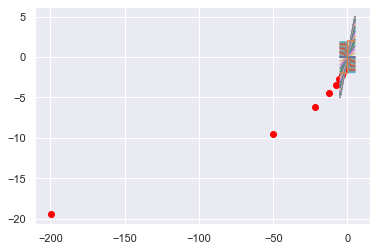

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def f1(x, theta):
    return (1 - theta**2) * x

def f2(x, theta):
    return 2 * theta * np.tanh(theta * x / (theta**2 - 1))

# Define the range of x values to plot
x = np.linspace(-5, 5, 1000)

# Define the range of theta values to plot
theta = np.linspace(0, 1, 21)

# Initialize arrays to store the intersection points
x0 = np.zeros(len(theta))
y0 = np.zeros(len(theta))

# Plot the functions for each value of theta
for i in range(len(theta)):
    plt.plot(x, f1(x, theta[i]), label='f1')
    plt.plot(x, f2(x, theta[i]), label='f2')

    # Find the intersection points
    roots = np.roots([1 - theta[i]**2, -2 * theta[i] / (theta[i]**2 - 1)])
    x0[i] = roots.real[0]
    y0[i] = f1(x0[i], theta[i])

    # Plot the intersection points
    plt.scatter(x0[i], y0[i], c='red', marker='o')

# Add legend and labels
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Intersection of two functions')

# Show the plot
plt.show()


# Hypersphere

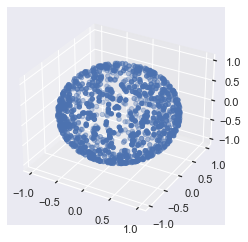

-11.190641043552137

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set the dimensionality of the hypersphere and number of samples
D = 3
N = 1000

# Generate random points sampled from the surface of the hypersphere
x = np.random.randn(D, N)
x /= np.linalg.norm(x, axis=0)

# Plot the data in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:], x[1,:], x[2,:])
plt.show()

x.sum()


In [93]:
x[0].sum()

4.468083542106772

D=1, r=1, Critical theta=0.6435942529055827


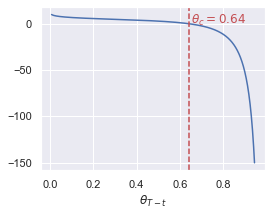

D=5, r=1, Critical theta=0.9054302307293239


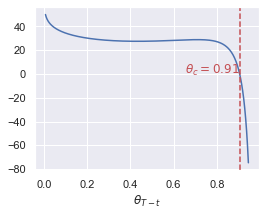

D=9, r=1, Critical theta=0.9460670130209485


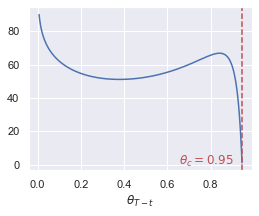

D=13, r=1, Critical theta=0.9623051175494943


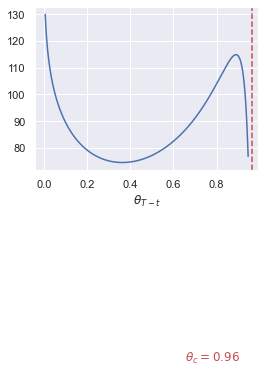

In [94]:
# spherical 

T = 1.
D = 6
r = 1

for D in range(1,16, 4): 
    # r =D
    beta_T_t = beta_min + (T-ts) * (beta_max-beta_min)
    second_derivative = -beta_T_t*(.5*D + ((D+r**2)*thetas**2 - D)/(thetas**2 -1)**2)

    # compute analytical value for theta critical point
    theta_c = np.sqrt((np.sqrt(D**2+r**2)-r)/D)
    print("D={}, r={}, Critical theta={}".format(D, r, theta_c))


    offset=900
    fig = plt.figure(figsize=(4,3))
    plt.plot(thetas[:offset], second_derivative[:offset])
    plt.axvline(x=theta_c, color='r', linestyle='--')
    plt.text(0.643+.01, 0, r'$\theta_c={:0.2f}$'.format(theta_c), color='r')
    plt.xlabel(r'$\theta_{T-t}$')
    # plt.ylabel(r"$\frac{\partial^2 U}{\partial x^2}|_{x=0}$")
    # fig.savefig(os.path.join(eval_dir, "./critical_point_theta.png"),  dpi=300, format='png', bbox_inches='tight')
    plt.show()

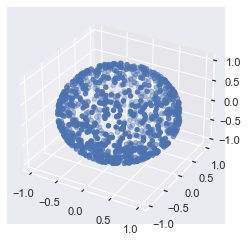

In [95]:
# Set the dimensionality of the hypersphere and number of samples
D = 3
N = 1000

# Generate random points sampled from the surface of the hypersphere
x = np.random.randn(D, N)
x /= np.linalg.norm(x, axis=0)

# Plot the data in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:], x[1,:], x[2,:])
plt.show()


In [98]:
import torch

# Define the number of data points
N = 1000

# Generate N random data points centered around 0
data = torch.randn(N)

data.sum()

tensor(24.1669)

# Phase transition prior Gaussian

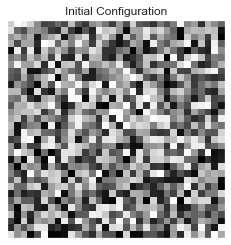

In [72]:
 # Set random seed for reproducibility
np.random.seed(42)

# Number of rows and columns in the grid
n_rows, n_cols = 32, 32

# Generate random samples from a standard normal distribution
x = np.random.normal(size=(n_rows, n_cols, 3))

# Normalize the samples to have unit length
norms = np.linalg.norm(x, axis=2)
x = x / norms[:,:,np.newaxis]

# Create a 2D plot
fig, ax = plt.subplots()

# Display the samples as an image
ax.imshow(x[:,:,0], cmap='gray')

# Remove the axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
plt.title('Initial Configuration')
# Show the plot
plt.show()

In [136]:
x.shape

(28, 28, 2)

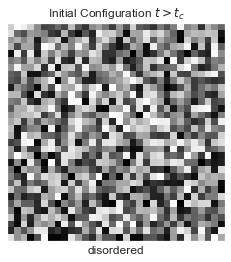

In [132]:
import numpy as np
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
sns.set_theme()

# Set random seed for reproducibility
np.random.seed(42)

# Number of rows and columns in the grid
n_rows, n_cols = 32, 32

# Generate random samples from a standard normal distribution
x = np.random.normal(size=(n_rows, n_cols, 3))

# Normalize the samples to have unit length
norms = np.linalg.norm(x, axis=2)
x = x / norms[:,:,np.newaxis]

# Create a 2D plot
fig, ax = plt.subplots()

# Display the samples as an image
ax.imshow(x[:,:,0], cmap='gray')

# Remove the axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
plt.title('Initial Configuration $t > t_c$')
plt.xlabel("disordered")
# Show the plot

fig.savefig(os.path.join(eval_dir, "./disordered.png"),  dpi=300, format='png', bbox_inches='tight')
plt.show()


In [133]:
delta_pdf = DeltaDist(dim=32*32*3, a=1, b=-1)
batch = delta_pdf.sample((1000,)).numpy() #.reshape(-1)
batch.shape

(1000, 3072)

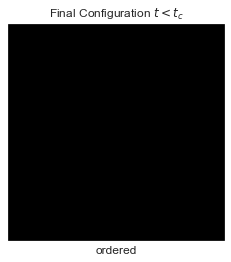

In [134]:
# Number of rows and columns in the grid
n_rows, n_cols = 32, 32

# Generate random samples from a standard normal distribution
x = batch[0].reshape(n_rows, n_cols, 3)

# Normalize the samples to have unit length
norms = np.linalg.norm(x, axis=2)
x = x / norms[:,:,np.newaxis]

# Create a 2D plot
fig, ax = plt.subplots()

# Display the samples as an image
ax.imshow(x[:,:,0], cmap='gray')

# Remove the axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
plt.title('Final Configuration $t < t_c$')
plt.xlabel("ordered")
# Show the plot

fig.savefig(os.path.join(eval_dir, "./ordered.png"),  dpi=300, format='png', bbox_inches='tight')
plt.show()